## Análise de anomalias em criptomoedas

O objetivo deste código é analisar o comportamento de modelos de predição de séries temporais por meio de aprendizado não supervisionado, em um sistema de **AutoEncoder**.

### Importações

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime, timedelta


Devido a limitações da biblioteca, é adquirdo os dados por minuto dos últimos 7 dias, gerando por volta de **40.000** resultados

In [2]:
end_date = datetime.now()
start_date = end_date - timedelta(days=7)

df = pd.DataFrame()

for i in range(4):
    btc_data = yf.download('BTC-USD', start=start_date, end=end_date, interval='1m')
    df = pd.concat([df, btc_data.iloc[::-1]])
    end_date = start_date
    start_date = end_date - timedelta(days=7)

df = df.iloc[::-1]

print(df.shape)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

(39203, 6)


### Pré Processamento

Devido aos valores retornados pelo yfinance de abertura e fechamento serem os mesmos, então é excluído todos, deixando somente uma única coluna, a "*Adj. Close*"

In [3]:
df = df.drop(["Open", "High", "Low", "Close", "Volume"], axis=1)

In [4]:
# Criando as janelas de 60 minutos para prever a próxima janela

WINDOW_SIZE = 60

X = []
y = []

for i in range(0, len(df) - 2*WINDOW_SIZE):
    X.append(df.iloc[i:i+WINDOW_SIZE].values)
    y.append(df.iloc[i+WINDOW_SIZE:i+2*WINDOW_SIZE].values)

X = np.array(X)
y = np.array(y)

(39083, 60, 1)
(39083, 60, 1)


In [26]:
def normalize(X_train, X_test, y_train, y_test):
    X_mean = X_train.mean(axis=1).mean(axis=0)
    X_std = X_train.std(axis=1).mean(axis=0)

    y_mean = y_train.mean(axis=1).mean(axis=0)
    y_std = y_train.std(axis=1).mean(axis=0)

    X_train = (X_train - X_mean) / X_std
    y_train = (y_train - y_mean) / y_std
    X_test = (X_test - X_mean) / X_std
    y_test = (y_test - y_mean) / y_std

    return X_train, X_test, y_train, y_test, (X_mean, X_std), (y_mean, y_std)

In [33]:
def split(X, y, train_size=0.8):
    i = int(X.shape[0] * train_size)
    X_train = X[:i]
    y_train = y[:i]
    X_test = X[i:]
    y_test = y[i:]

    return X_train, X_test, y_train, y_test

In [34]:
X_train, X_test, y_train, y_test = split(X, y)

X_train, X_test, y_train, y_test, scaler_X, scaler_y = normalize(X_train, X_test, y_train, y_test)

### Modelos

In [35]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=50,input_shape=(X.shape[1], X.shape[2])),
    tf.keras.layers.Dropout(rate=0.2),

    tf.keras.layers.RepeatVector(n=X.shape[1]),
    tf.keras.layers.LSTM(units=50, return_sequences=True),

    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=1))
])

model.compile(
    loss="mean_squared_error",
    optimizer="adam"
)

In [36]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 50)                10400     
                                                                 
 dropout_6 (Dropout)         (None, 50)                0         
                                                                 
 repeat_vector_3 (RepeatVec  (None, 60, 50)            0         
 tor)                                                            
                                                                 
 lstm_7 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_7 (Dropout)         (None, 60, 50)            0         
                                                                 
 time_distributed_3 (TimeDi  (None, 60, 1)             51        
 stributed)                                           

In [37]:
model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
196/196 [==============================] - 17s 71ms/step - loss: 2384.6362 - val_loss: 1999.1067
Epoch 2/10
196/196 [==============================] - 14s 74ms/step - loss: 1475.4725 - val_loss: 1262.9106
Epoch 3/10
196/196 [==============================] - 15s 76ms/step - loss: 972.5993 - val_loss: 774.5189
Epoch 4/10
196/196 [==============================] - 16s 79ms/step - loss: 639.1345 - val_loss: 463.9833
Epoch 5/10
196/196 [==============================] - 16s 84ms/step - loss: 414.1640 - val_loss: 263.6872
Epoch 6/10
196/196 [==============================] - 16s 79ms/step - loss: 264.7373 - val_loss: 143.1805
Epoch 7/10
196/196 [==============================] - 15s 76ms/step - loss: 168.3112 - val_loss: 76.5702
Epoch 8/10
196/196 [==============================] - 16s 84ms/step - loss: 108.8231 - val_loss: 42.3947
Epoch 9/10
196/196 [==============================] - 16s 80ms/step - loss: 74.6126 - val_loss: 26.0606
Epoch 10/10
196/196 [=========================

In [38]:
predicted = model.predict(X_test)

245/245 [==============================] - 3s 10ms/step


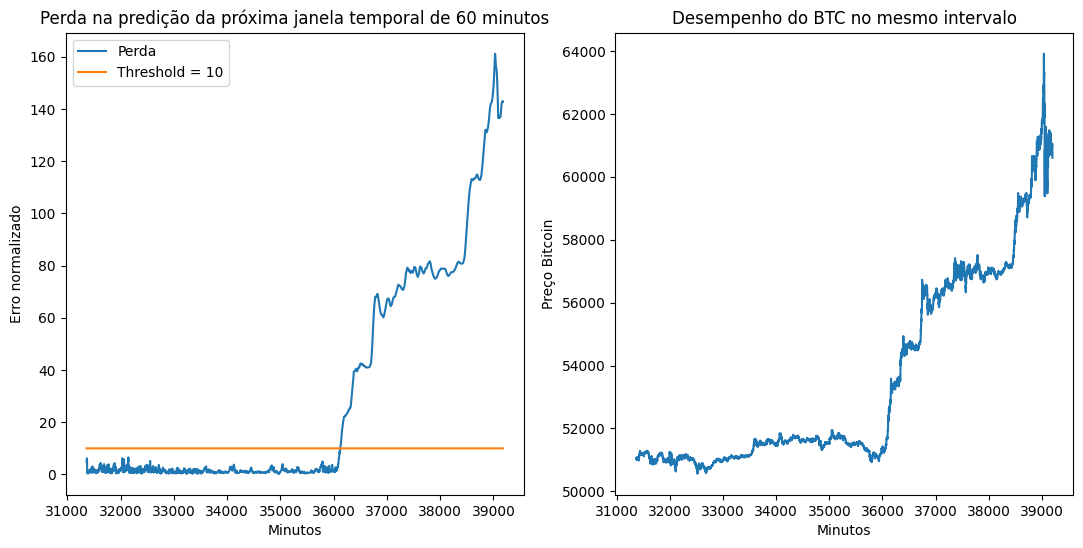

In [88]:
error = y_test - predicted

init = (df.shape[0]*8) // 10

loss = np.mean(np.abs(error), axis=1)

figure, axis = plt.subplots(1, 2, figsize=(13, 6))

axis[0].plot(np.arange(init, init + loss.shape[0]), loss, label='Perda')
axis[0].plot(np.arange(init, init+loss.shape[0]), np.full_like(loss, 10), label='Threshold = 10')

axis[0].legend()
axis[0].set_title("Perda na predição da próxima janela temporal de 60 minutos")
axis[0].set_ylabel("Erro normalizado")
axis[0].set_xlabel("Minutos")

axis[1].plot(df["Adj Close"].reset_index(drop=True).loc[init:])
axis[1].set_title("Desempenho do BTC no mesmo intervalo")
axis[1].set_xlabel("Minutos")
axis[1].set_ylabel("Preço Bitcoin")
plt.show()    